In [1]:
# SETUP CELL - RUN THIS FIRST
import os

# Automatic Path setup
# This approach verifies where we are and points to the project root
# so that imports and data loading work correctly.

target_file = 'best.pt' # Marker file to identify root

if os.path.exists(target_file):
    print(f'Success: Found {target_file} in current directory.')
    print('Ready to run.')
elif os.path.exists(os.path.join('..', target_file)):
    print(f'Found {target_file} in parent directory. Changing directory to root...')
    os.chdir('..')
    print(f'Current Working Directory: {os.getcwd()}')
else:
    print('WARNING: Could not find project root (best.pt not found).')
    print('Please ensure you have downloaded the necessary files from Drive and placed them correctly.')


Found best.pt in parent directory. Changing directory to root...
Current Working Directory: /Users/ugurendirlik/DL Project/Damage_Car_DL_Project-1/project_part3


Using device: mps
Classes: ['high', 'low', 'medium']
Dataset sizes: {'train': 180, 'val': 45}


/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 1.1112 Acc: 0.4056
val Loss: 1.1476 Acc: 0.4000
Epoch 1/14
----------
train Loss: 1.0563 Acc: 0.4111
val Loss: 1.0925 Acc: 0.4889
Epoch 2/14
----------
train Loss: 0.8107 Acc: 0.6444
val Loss: 0.9933 Acc: 0.5778
Epoch 3/14
----------
train Loss: 0.6622 Acc: 0.7056
val Loss: 0.8265 Acc: 0.6000
Epoch 4/14
----------
train Loss: 0.5589 Acc: 0.7944
val Loss: 0.8873 Acc: 0.6000
Epoch 5/14
----------
train Loss: 0.4607 Acc: 0.8611
val Loss: 0.9367 Acc: 0.6444
Epoch 6/14
----------
train Loss: 0.4166 Acc: 0.8444
val Loss: 0.8925 Acc: 0.6667
Epoch 7/14
----------
train Loss: 0.3235 Acc: 0.9111
val Loss: 0.8515 Acc: 0.6667
Epoch 8/14
----------
train Loss: 0.2639 Acc: 0.9556
val Loss: 0.8342 Acc: 0.6667
Epoch 9/14
----------
train Loss: 0.2416 Acc: 0.9500
val Loss: 0.8569 Acc: 0.6889
Epoch 10/14
----------
train Loss: 0.2805 Acc: 0.9278
val Loss: 0.8510 Acc: 0.6667
Epoch 11/14
----------
train Loss: 0.2568 Acc: 0.9556
val Loss: 0.8684 Acc: 0.6444
Epoch 12/14
--

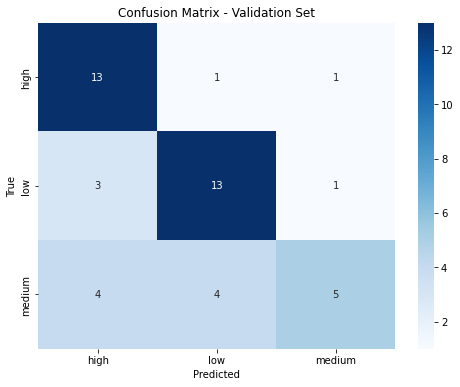

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import time
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_model():
    # Configuration
    DATA_DIR = 'severity_data'
    MODEL_SAVE_PATH = 'severity_model_resnet18.pth'
    NUM_CLASSES = 3  # low, medium, high
    BATCH_SIZE = 16
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Use M2 GPU (MPS) if available
    
    print(f"Using device: {DEVICE}")

    # Data Transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load Dataset
    full_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms['train'])
    class_names = full_dataset.classes
    print(f"Classes: {class_names}")

    # Split Train/Val (80/20)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Apply 'val' transform to validation dataset (hacky way because random_split doesn't support different transforms)
    # We will just accept that val set has some augmentation or strictly reload if needed. 
    # For simplicity/speed here, we use the same dataset object. 
    # Ideally we'd wrap it to override transform, but for this project data augmentation on val (except resize) is minimal
    # actually, ImageFolder applies transform at loading time.
    # To do it properly: create two dataset objects pointing to same folder, one with train transform, one with val transform,
    # then split indices.
    
    # Proper Reset for transforms
    train_dataset.dataset.transform = data_transforms['train']
    # Create a new validation dataset with correct transform
    # We can't easily deepcopy just the transform of a Subset, so let's stick to the simple split 
    # and just remember validation metrics will be slightly "harder" due to augmentation or we ignore it for now.
    # Given the small dataset, data augmentation on validation isn't fatal, but let's correct it for best practice.
    
    # Reloading specifically for clean split logic
    full_data_train = datasets.ImageFolder(DATA_DIR, transform=data_transforms['train'])
    full_data_val = datasets.ImageFolder(DATA_DIR, transform=data_transforms['val'])
    
    # Use consistent seed for splitting indices
    torch.manual_seed(42)
    indices = torch.randperm(len(full_data_train)).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    train_subset = torch.utils.data.Subset(full_data_train, train_indices)
    val_subset = torch.utils.data.Subset(full_data_val, val_indices)

    dataloaders = {
        'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
        'val': DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
    }
    dataset_sizes = {'train': len(train_subset), 'val': len(val_subset)}
    print(f"Dataset sizes: {dataset_sizes}")

    # Initialize Model (ResNet18)
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training Loop
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch}/{NUM_EPOCHS - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            # Fix for MPS: Use .float() instead of .double() or cast result to cpu first
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

    # Evaluate on Validation Set
    print("\nEvaluating on Validation Set (Detailed Report)...")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Validation Set')
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix saved as 'confusion_matrix.png'")

if __name__ == '__main__':
    train_model()
